**2.156 Final Project**

Load Data from dropbox

In [78]:
import os
import shutil
import random
import pathlib
import requests
from urllib.parse import urlencode, urlparse, parse_qsl, urlunparse

data_dir = "https://www.dropbox.com/scl/fo/3d3kttc96e8a5izrhr9du/ABGbVWFKYaUZNu9jtNVnwDY?rlkey=lvo18dm41lb4jbyarzznvwtvx&st=gv5sxb2t&dl=0"
source_root = "data/source_dataset"
target_root = "data/split_dataset"
def _to_direct_dropbox(url):
    parsed = urlparse(url)
    if "dropbox.com" not in parsed.netloc:
        return url
    query = dict(parse_qsl(parsed.query))
    query["dl"] = "1"
    return urlunparse(parsed._replace(query=urlencode(query)))

download_url = _to_direct_dropbox(data_dir)
source_root_path = pathlib.Path(source_root)
zip_path = source_root_path.parent / "source_dataset.zip"
source_root_path.mkdir(parents=True, exist_ok=True)

with requests.get(download_url, stream=True) as resp:
    resp.raise_for_status()
    with open(zip_path, "wb") as fh:
        for chunk in resp.iter_content(chunk_size=8192):
            if chunk:
                fh.write(chunk)

shutil.unpack_archive(str(zip_path), str(source_root_path))
zip_path.unlink()

gitignore_path = pathlib.Path(".gitignore")
gitignore_entries = {source_root.rstrip("/"), target_root.rstrip("/")}
existing = set()
if gitignore_path.exists():
    existing = {line.strip() for line in gitignore_path.read_text().splitlines() if line.strip()}
with gitignore_path.open("a") as f:
    for entry in sorted(gitignore_entries):
        if entry not in existing:
            f.write(entry + "\n")

splits = ["train", "val", "test"]
ratios = {"train": 0.7, "val": 0.15, "test": 0.15}

# Create target folders
# for split in splits:
#     for class_name in os.listdir(source_root):
#         os.makedirs(os.path.join(target_root, split, class_name), exist_ok=True)

# # Split the data per class
# for class_name in os.listdir(source_root):
#     class_dir = os.path.join(source_root, class_name)
#     if not os.path.isdir(class_dir):
#         continue

#     images = os.listdir(class_dir)
#     random.shuffle(images)

#     n = len(images)
#     n_train = int(n * ratios["train"])
#     n_val   = int(n * ratios["val"])

#     train_files = images[:n_train]
#     val_files   = images[n_train:n_train+n_val]
#     test_files  = images[n_train+n_val:]

#     for f in train_files:
#         shutil.copy(os.path.join(class_dir, f),
#                     os.path.join(target_root, "train", class_name, f))
#     for f in val_files:
#         shutil.copy(os.path.join(class_dir, f),
#                     os.path.join(target_root, "val", class_name, f))
#     for f in test_files:
#         shutil.copy(os.path.join(class_dir, f),
#                     os.path.join(target_root, "test", class_name, f))
# print("Dataset split completed.")
# Clean list: only real class folders (skip hidden files)
class_folders = [
    d for d in os.listdir(source_root)
    if os.path.isdir(os.path.join(source_root, d)) and not d.startswith(".") and d != "__MACOSX"
]

print("Detected class folders:", len(class_folders))

splits = ["train", "val", "test"]
ratios = {"train": 0.7, "val": 0.15, "test": 0.15}

# Create target folders
for split in splits:
    for class_name in class_folders:
        os.makedirs(os.path.join(target_root, split, class_name), exist_ok=True)

# Split data per class
for class_name in class_folders:
    class_dir = os.path.join(source_root, class_name)

    images = [
        f for f in os.listdir(class_dir)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    random.shuffle(images)

    n = len(images)
    n_train = int(n * ratios["train"])
    n_val   = int(n * ratios["val"])

    train_files = images[:n_train]
    val_files   = images[n_train:n_train+n_val]
    test_files  = images[n_train+n_val:]

    # copy files
    for f in train_files:
        shutil.copy(os.path.join(class_dir, f),
                    os.path.join(target_root, "train", class_name, f))
    for f in val_files:
        shutil.copy(os.path.join(class_dir, f),
                    os.path.join(target_root, "val", class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(class_dir, f),
                    os.path.join(target_root, "test", class_name, f))

print("Dataset split completed successfully.")


Detected class folders: 93
Dataset split completed successfully.


In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm, trange
import seaborn as sns
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load Images

In [80]:
from torchvision import transforms
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

train_transform = transforms.Compose([
    transforms.Resize(256),                    # shorter side to 256
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.25)           # optional + gentler
])


eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [81]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

#base_dir = "/Users/rebeccasholler/Library/CloudStorage/Dropbox/CouplingRenderings/Renderings_split"

from torchvision import datasets, transforms

train_data = datasets.ImageFolder("data/split_dataset/train", transform=train_transform)
val_data   = datasets.ImageFolder("data/split_dataset/val", transform=eval_transform)
test_data  = datasets.ImageFolder("data/split_dataset/test", transform=eval_transform)


# train_files = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=train_transform)
# val_files   = datasets.ImageFolder(os.path.join(base_dir, "val"),   transform=eval_transform)
# test_files  = datasets.ImageFolder(os.path.join(base_dir, "test"),  transform=eval_transform)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)


We will want to visualize the data next but will add that in when data is complete

In [34]:
!pip install open_clip_torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00


In [82]:
import open_clip
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP ViT-B/32
clip_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
    'ViT-B-32', pretrained='laion2b_s34b_b79k'
)

clip_model = clip_model.to(device)
clip_model.eval()  # we'll freeze it in the classifier class

embed_dim = clip_model.visual.output_dim  # feature dimension from encoder


In [83]:
from torch.utils.data import Dataset
import torch

class MultiViewImageDataset(Dataset):
    def __init__(self, root, base_transform, num_views=4):
        # Use ImageFolder to get file paths + labels, but handle transforms ourselves
        self.folder = datasets.ImageFolder(root, transform=None)
        self.transform = base_transform
        self.num_views = num_views
        self.classes = self.folder.classes
        self.samples = self.folder.samples
        self.loader = self.folder.loader

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = self.loader(path)

        # Generate V different augmented views of the same image
        views = [self.transform(img) for _ in range(self.num_views)]
        views = torch.stack(views, dim=0)  # [V, C, H, W]

        return views, label


In [84]:
num_views = 2

train_data = MultiViewImageDataset("data/split_dataset/train", preprocess_train, num_views=num_views)
val_data   = MultiViewImageDataset("data/split_dataset/val",   preprocess_val,   num_views=num_views)
test_data  = MultiViewImageDataset("data/split_dataset/test",  preprocess_val,   num_views=num_views)

batch_size = 16  # smaller batch because V views per image
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(train_data.classes)


In [85]:
class CLIPMultiViewClassifier(nn.Module):
    def __init__(self, clip_model, embed_dim, num_classes, freeze_backbone=True):
        super().__init__()
        self.clip = clip_model

        if freeze_backbone:
            for p in self.clip.parameters():
                p.requires_grad = False

        self.classifier = nn.Sequential(nn.Linear(embed_dim, 512), nn.ReLU(), nn.Linear(512, num_classes))

    def forward(self, views):
        """
        views: [B, V, C, H, W]
        """
        B, V, C, H, W = views.shape

        # Flatten views into batch dimension
        views = views.view(B * V, C, H, W)  # [B*V, C, H, W]

        # Encode each view with CLIP
        feats = self.clip.encode_image(views)        # [B*V, D]
        feats = feats / feats.norm(dim=-1, keepdim=True)  # L2 normalize

        # Reshape back to [B, V, D] and aggregate (mean over views)
        feats = feats.view(B, V, -1).mean(dim=1)     # [B, D]

        # Classifier head
        logits = self.classifier(feats)              # [B, num_classes]
        return logits


In [86]:
import numpy as np

train_labels = [label for _, label in train_data.samples]
class_counts = np.bincount(train_labels)
print("Class counts:", class_counts)

class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.mean()
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [27 28 27 27 28 28 29 28 26 27 29 29 27 27 26 28 30 26 26 29 28 29 27 26
 27 28 28 27 26 26 27 26 29 28 28 27 27 28 28 27 28 25 27 55 54 56 54 54
 54 55 56 55 55 53 53 54 28 26 27 27 25 28 28 27 28 26 25 25 26 27 26 28
 27 27 27 28 27 29 26 54 57 56 55 52 55 54 55 57 51 56 54 55 55]


In [87]:
def train_clip_multiview(
    model,
    train_loader,
    val_loader,
    num_epochs=20,
    lr=3e-3,
    weight_decay=1e-4,
    device="cuda",
    criterion=None,
):
    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses, val_losses, val_accuracies = [], [], []
    best_val_acc = 0.0
    best_state = None

    for epoch in range(num_epochs):
        # ----- TRAIN -----
        model.train()
        running_loss = 0.0

        for views, labels in train_loader:
            views = views.to(device)      # [B, V, C, H, W]
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(views)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * views.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # ----- VAL -----
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for views, labels in val_loader:
                views = views.to(device)
                labels = labels.to(device)

                outputs = model(views)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * views.size(0)

                _, preds = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_loss = epoch_val_loss
        val_acc = correct / total

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {epoch_train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_acc:.4f}"
        )

    if best_state is not None:
        model.load_state_dict(best_state)
    print(f"Best Val Acc: {best_val_acc:.4f}")

    return train_losses, val_losses, val_accuracies, best_val_acc


In [88]:
views, labels = next(iter(train_loader))
print("views shape:", views.shape)  # should be [B, V, C, H, W]

views = views.to(device)
model = CLIPMultiViewClassifier(clip_model, embed_dim, num_classes).to(device)
with torch.no_grad():
    out = model(views)
print("logits shape:", out.shape)   # should be [B, num_classes]


views shape: torch.Size([16, 2, 3, 224, 224])
logits shape: torch.Size([16, 93])


In [89]:
train_losses, val_losses, val_accs, best_val_acc = train_clip_multiview(
    model,
    train_loader,
    val_loader,
    num_epochs=40,
    lr=3e-3,
    weight_decay=1e-4,
    device=device,
    criterion=criterion,
)


Epoch 1/40 | Train Loss: 3.3140 | Val Loss: 2.6065 | Val Acc: 0.1400
Epoch 2/40 | Train Loss: 2.4067 | Val Loss: 2.2353 | Val Acc: 0.2158
Epoch 3/40 | Train Loss: 2.0837 | Val Loss: 1.9415 | Val Acc: 0.3013
Epoch 4/40 | Train Loss: 1.8398 | Val Loss: 1.7904 | Val Acc: 0.3387
Epoch 5/40 | Train Loss: 1.6626 | Val Loss: 1.6500 | Val Acc: 0.4017
Epoch 6/40 | Train Loss: 1.5206 | Val Loss: 1.4894 | Val Acc: 0.4530
Epoch 7/40 | Train Loss: 1.4055 | Val Loss: 1.4220 | Val Acc: 0.4615
Epoch 8/40 | Train Loss: 1.3204 | Val Loss: 1.3372 | Val Acc: 0.5053
Epoch 9/40 | Train Loss: 1.2062 | Val Loss: 1.3018 | Val Acc: 0.5556
Epoch 10/40 | Train Loss: 1.1346 | Val Loss: 1.2307 | Val Acc: 0.5470
Epoch 11/40 | Train Loss: 1.0814 | Val Loss: 1.1972 | Val Acc: 0.5684
Epoch 12/40 | Train Loss: 1.0121 | Val Loss: 1.1496 | Val Acc: 0.5759
Epoch 13/40 | Train Loss: 0.9461 | Val Loss: 1.0573 | Val Acc: 0.6175
Epoch 14/40 | Train Loss: 0.8845 | Val Loss: 1.0653 | Val Acc: 0.6165
Epoch 15/40 | Train Loss: 0.8

In [90]:
save_path = "model_clip.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "num_classes": num_classes,
    "class_names": class_names,
}, save_path)

print("Saved:", save_path)


Saved: model_clip.pth


In [91]:
import torch
import numpy as np

model.eval()
model.to(device)

all_logits = []
all_labels = []
all_embeddings = []

with torch.no_grad():
    for views, labels in test_loader:
        views = views.to(device)   # [B, V, C, H, W]
        labels = labels.to(device)

        # Forward pass (logits)
        logits = model(views)      # [B, num_classes]

        # Get embeddings from CLIP without classifier
        B, V, C, H, W = views.shape
        flat_views = views.view(B * V, C, H, W)
        feats = model.clip.encode_image(flat_views)          # [B*V, D]
        feats = feats / feats.norm(dim=-1, keepdim=True)
        feats = feats.view(B, V, -1).mean(dim=1)             # [B, D]

        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
        all_embeddings.append(feats.cpu())

all_logits = torch.cat(all_logits, dim=0)           # [N, num_classes]
all_labels = torch.cat(all_labels, dim=0).numpy()   # [N]
all_embeddings = torch.cat(all_embeddings, dim=0).numpy()  # [N, D]

pred_probs = torch.softmax(all_logits, dim=1).numpy()
pred_top1 = pred_probs.argmax(axis=1)


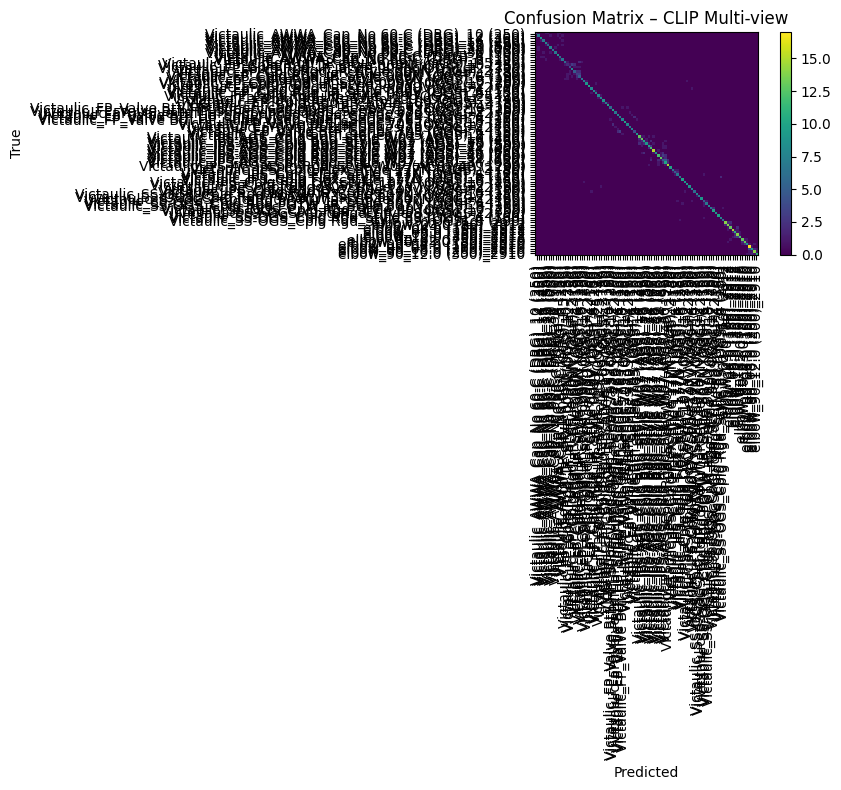

In [92]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, pred_top1)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix – CLIP Multi-view")

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names)

plt.tight_layout()
plt.show()


Top-1: 0.777, Top-3: 0.945, Top-5: 0.982


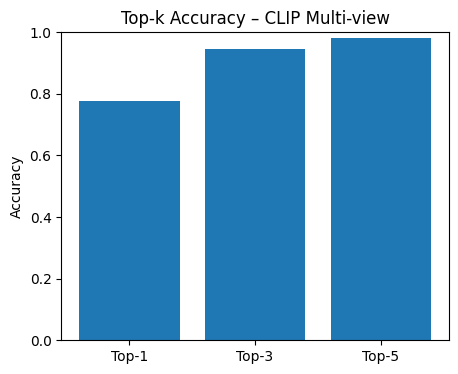

In [93]:
def topk_accuracy(probs, labels, k):
    topk_idx = np.argsort(-probs, axis=1)[:, :k]  # top k indices
    match = (topk_idx == labels[:, None]).any(axis=1)
    return match.mean()

top1 = topk_accuracy(pred_probs, all_labels, k=1)
top3 = topk_accuracy(pred_probs, all_labels, k=3)
top5 = topk_accuracy(pred_probs, all_labels, k=5)

print(f"Top-1: {top1:.3f}, Top-3: {top3:.3f}, Top-5: {top5:.3f}")

plt.figure(figsize=(5,4))
plt.bar(["Top-1", "Top-3", "Top-5"], [top1, top3, top5])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Top-k Accuracy – CLIP Multi-view")
plt.show()


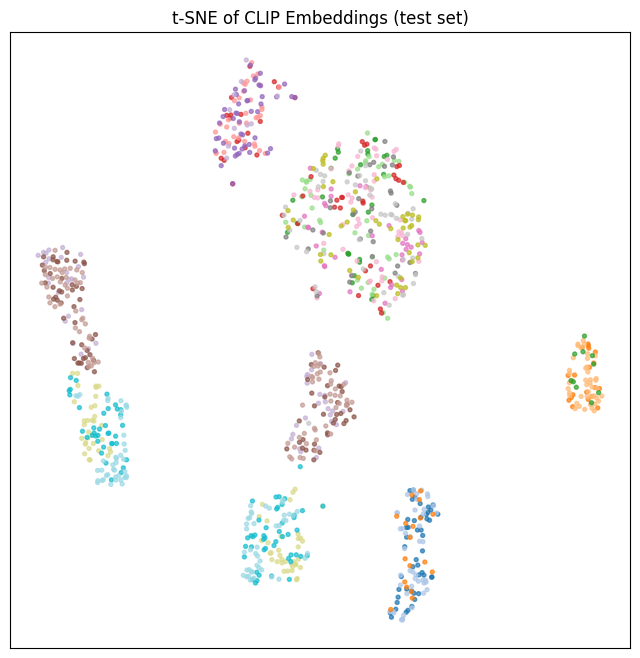

In [94]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init="random", random_state=42)
emb_2d = tsne.fit_transform(all_embeddings)   # [N, 2]

plt.figure(figsize=(8, 8))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=all_labels, s=8, alpha=0.7, cmap='tab20')
plt.title("t-SNE of CLIP Embeddings (test set)")
plt.xticks([]); plt.yticks([])
plt.show()


In [95]:
# assumes train_data is a standard ImageFolder
train_paths = [s[0] for s in train_data.samples]
train_labels_arr = np.array([s[1] for s in train_data.samples])

train_embeddings = []
model.eval()
with torch.no_grad():
    for views, labels in train_loader:
        # For train_loader we used MultiViewImageDataset too
        views = views.to(device)
        B, V, C, H, W = views.shape
        flat_views = views.view(B * V, C, H, W)
        feats = model.clip.encode_image(flat_views)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        feats = feats.view(B, V, -1).mean(dim=1)
        train_embeddings.append(feats.cpu())

train_embeddings = torch.cat(train_embeddings, dim=0).numpy()  # [N_train, D]


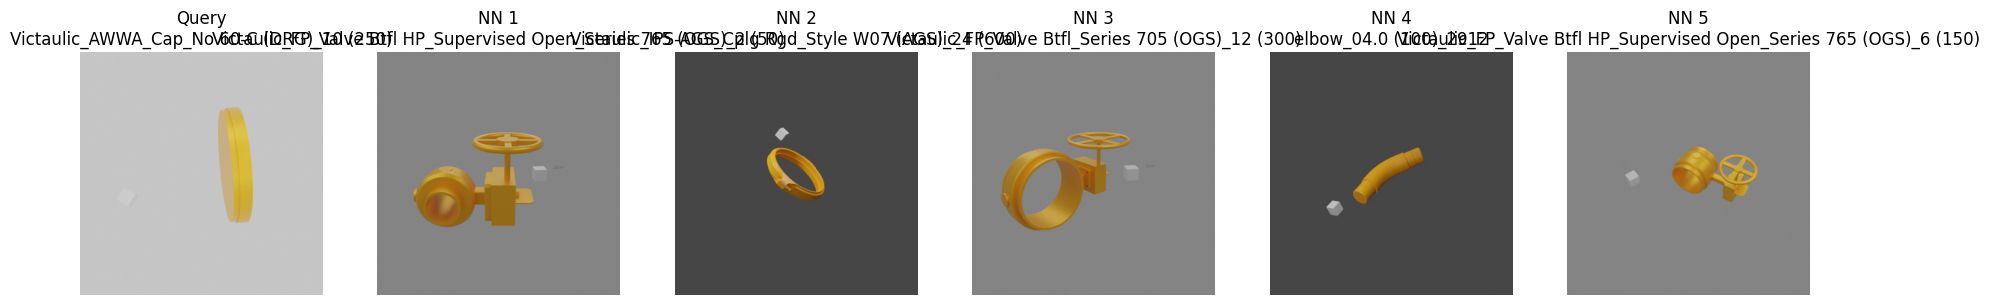

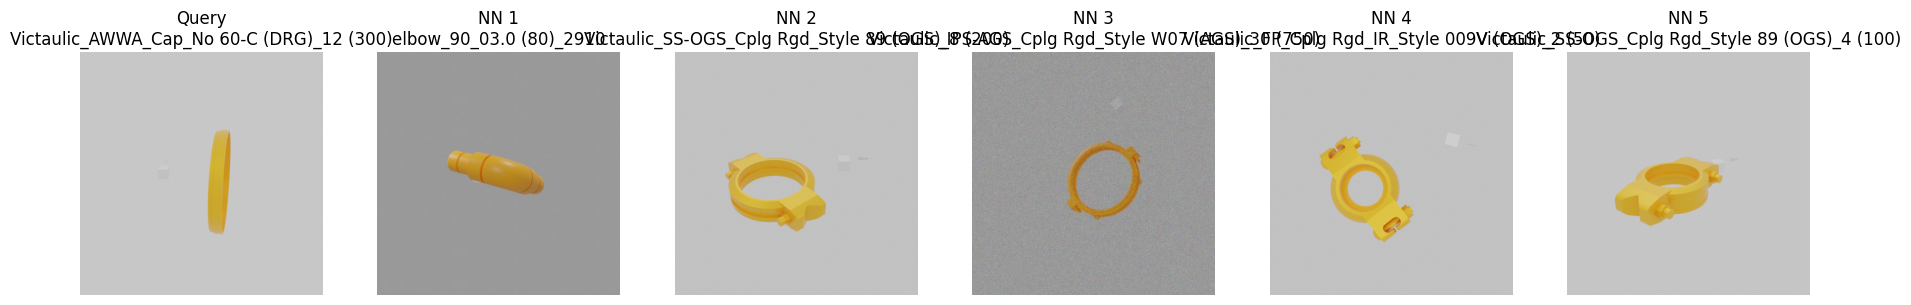

In [97]:
from PIL import Image

def show_retrieval_example(query_idx, k=5):
    q_emb = all_embeddings[query_idx:query_idx+1]    # [1, D]
    # cosine similarity
    sim = (train_embeddings @ q_emb.T).ravel()       # [N_train]
    nn_idx = np.argsort(-sim)[:k]                    # top-k

    fig, axes = plt.subplots(1, k+1, figsize=(3*(k+1), 3))

    # Query image (from test_data)
    q_path, q_label = test_data.samples[query_idx]
    q_img = Image.open(q_path).convert("RGB")
    axes[0].imshow(q_img)
    axes[0].set_title(f"Query\n{class_names[q_label]}")
    axes[0].axis("off")

    for i, idx in enumerate(nn_idx):
        path = train_paths[idx]
        lbl = train_labels_arr[idx]
        img = Image.open(path).convert("RGB")
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"NN {i+1}\n{class_names[lbl]}")
        axes[i+1].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
show_retrieval_example(query_idx=0, k=5)
show_retrieval_example(query_idx=10, k=5)


In [98]:
same_sim = []
diff_sim = []

model.eval()
with torch.no_grad():
    for views, labels in test_loader:
        views = views.to(device)       # [B, V, C, H, W]
        B, V, C, H, W = views.shape

        flat_views = views.view(B * V, C, H, W)
        feats = model.clip.encode_image(flat_views)          # [B*V, D]
        feats = feats / feats.norm(dim=-1, keepdim=True)
        feats = feats.view(B, V, -1)                         # [B, V, D]

        # same-part similarity: average pairwise similarity across views
        for b in range(B):
            f = feats[b]                                     # [V, D]
            sim_mat = f @ f.T                                # [V, V]
            # remove diagonal and upper triangle; keep lower tri
            tril = np.tril_indices(V, k=-1)
            same_sim.extend(sim_mat[tril].cpu().numpy())

        # different-part similarity: compare first view of each sample in batch
        v0 = feats[:, 0, :]                                  # [B, D]
        sim = v0 @ v0.T                                      # [B, B]
        tril = np.tril_indices(B, k=-1)
        diff_sim.extend(sim[tril].cpu().numpy())


/usr/local/lib/python3.12/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.12/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


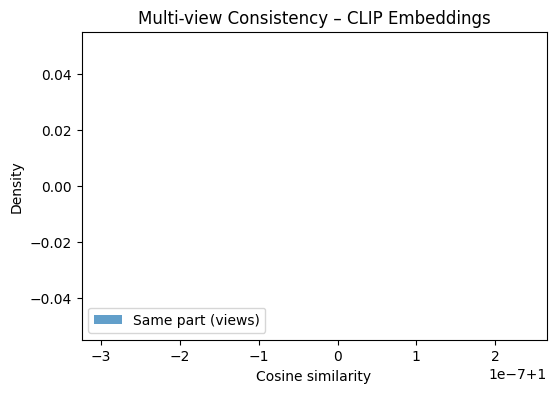

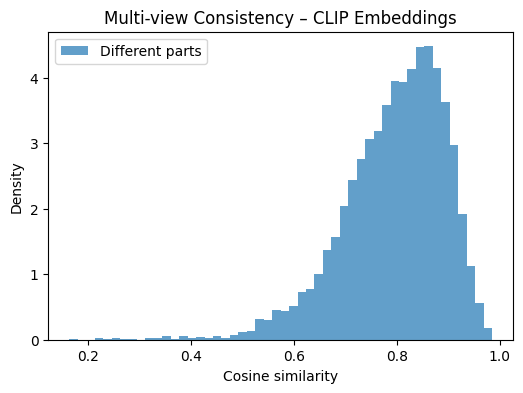

In [99]:
plt.figure(figsize=(6,4))
plt.hist(same_sim, bins=50, alpha=0.7, label="Same part (views)", density=True)
plt.xlabel("Cosine similarity")
plt.ylabel("Density")
plt.title("Multi-view Consistency – CLIP Embeddings")
plt.legend()
plt.show()
plt.figure(figsize=(6,4))
plt.hist(diff_sim, bins=50, alpha=0.7, label="Different parts", density=True)
plt.xlabel("Cosine similarity")
plt.ylabel("Density")
plt.title("Multi-view Consistency – CLIP Embeddings")
plt.legend()
plt.show()


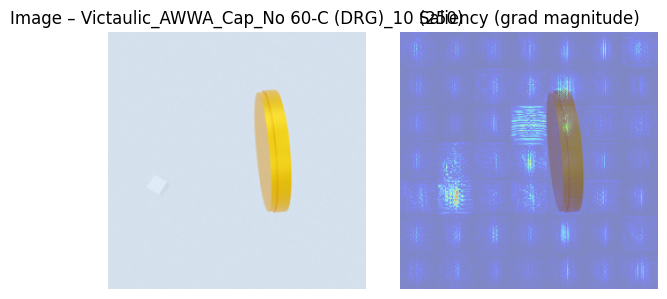

In [100]:
def saliency_for_example(idx):
    model.eval()
    # get one batch sample
    views, label = test_data[idx]      # views: [V, C, H, W], label: int
    views = views.unsqueeze(0).to(device)   # [1, V, C, H, W]
    label_t = torch.tensor([label], device=device)

    views.requires_grad_()

    logits = model(views)              # [1, num_classes]
    loss = logits[0, label_t]          # score for true class
    loss.backward()

    # grad wrt input views
    grads = views.grad.detach()        # [1, V, C, H, W]
    grads = grads.abs().max(dim=2)[0]  # max over channels -> [1, V, H, W]
    grads = grads.mean(dim=1)[0]       # mean over views -> [H, W]

    # normalize
    g = grads.cpu().numpy()
    g = (g - g.min()) / (g.max() - g.min() + 1e-8)

    # visualize on top of one of the original views
    import matplotlib.pyplot as plt
    from torchvision.transforms.functional import to_pil_image

    base_img = views.detach()[0, 0].cpu()  # first view, [C,H,W]
    base_img = (base_img - base_img.min()) / (base_img.max() - base_img.min() + 1e-8)
    base_pil = to_pil_image(base_img)

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(base_pil)
    plt.title(f"Image – {class_names[label]}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(base_pil)
    plt.imshow(g, cmap="jet", alpha=0.4)
    plt.title("Saliency (grad magnitude)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example:
saliency_for_example(0)


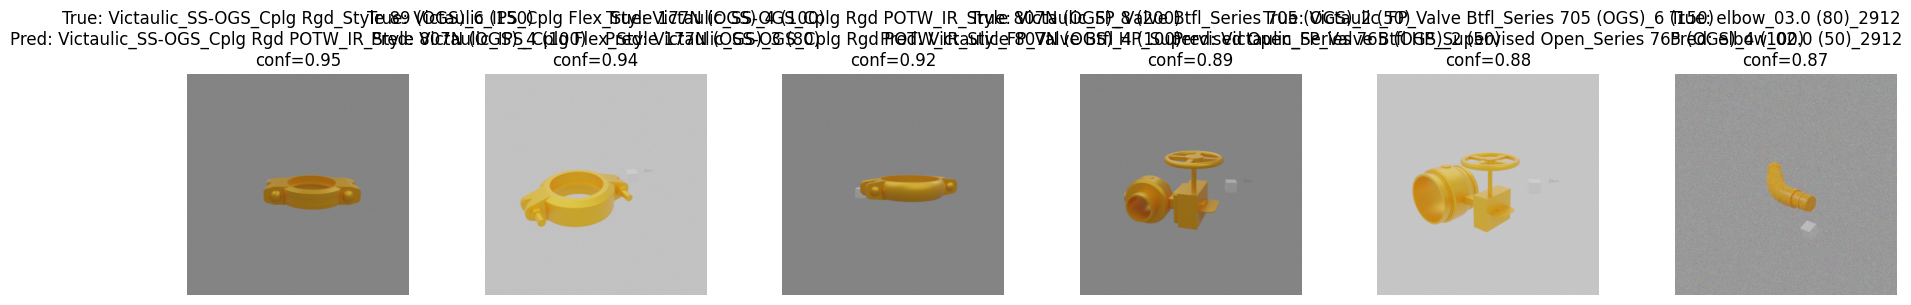

In [101]:
true = all_labels
pred = pred_top1
conf = pred_probs.max(axis=1)

wrong_idx = np.where(pred != true)[0]
wrong_conf = conf[wrong_idx]
sorted_wrong = wrong_idx[np.argsort(-wrong_conf)]  # highest confidence errors first

from PIL import Image

def show_error_gallery(n=8):
    n = min(n, len(sorted_wrong))
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))

    for i in range(n):
        idx = sorted_wrong[i]
        path, label = test_data.samples[idx]
        img = Image.open(path).convert("RGB")
        axes[i].imshow(img)
        axes[i].set_title(
            f"True: {class_names[true[idx]]}\nPred: {class_names[pred[idx]]}\nconf={conf[idx]:.2f}"
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

show_error_gallery(6)


/tmp/ipython-input-4135429892.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


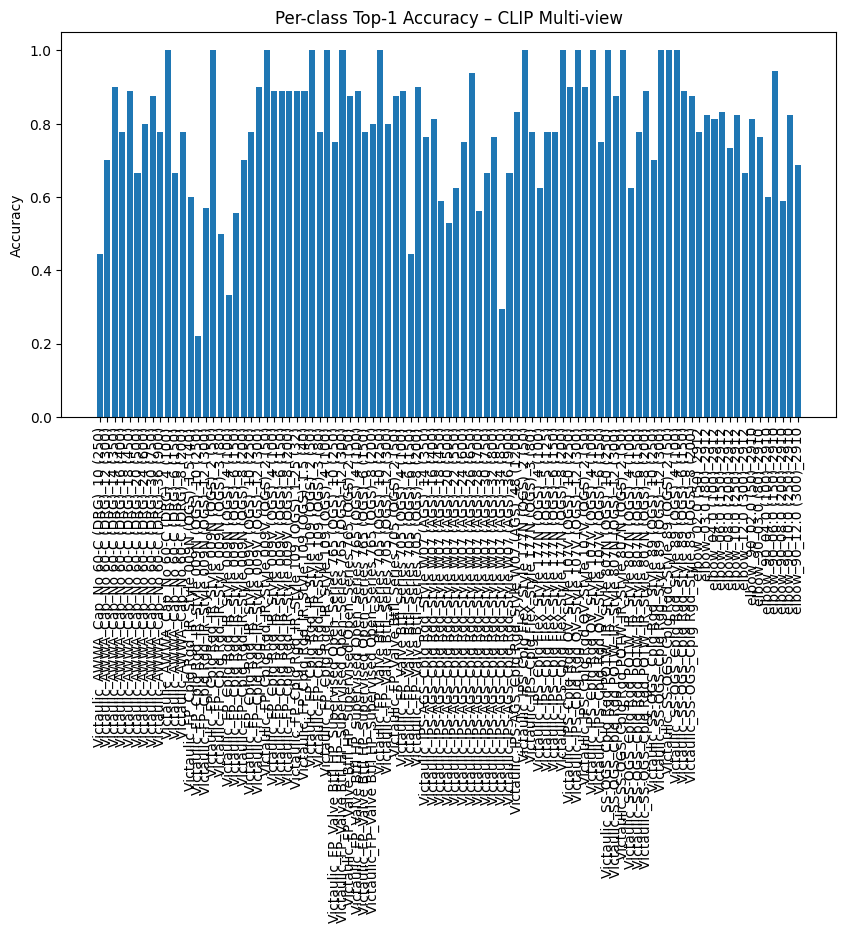

In [102]:
num_classes = len(class_names)
correct_per_class = np.zeros(num_classes, dtype=int)
total_per_class = np.zeros(num_classes, dtype=int)

for t, p in zip(true, pred):
    total_per_class[t] += 1
    if t == p:
        correct_per_class[t] += 1

acc_per_class = correct_per_class / np.maximum(total_per_class, 1)

plt.figure(figsize=(10,5))
plt.bar(np.arange(num_classes), acc_per_class)
plt.xticks(np.arange(num_classes), class_names, rotation=90)
plt.ylabel("Accuracy")
plt.title("Per-class Top-1 Accuracy – CLIP Multi-view")
plt.tight_layout()
plt.show()


In [104]:
train_paths = [p for p, _ in train_data.samples]
train_labels = np.array([l for _, l in train_data.samples])

train_feats = []
model.eval()

with torch.no_grad():
    for views, labels in train_loader:
        views = views.to(device)
        B, V, C, H, W = views.shape

        x = views.view(B * V, C, H, W)
        feats = model.clip.encode_image(x)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        feats = feats.view(B, V, -1).mean(dim=1)

        train_feats.append(feats.cpu())

train_feats = torch.cat(train_feats, dim=0).numpy()


In [105]:
from PIL import Image

def retrieve_similar(test_idx, k=5):
    # get test embedding
    views, label = test_data[test_idx]
    views = views.unsqueeze(0).to(device)   # [1, V, C, H, W]
    B,V,C,H,W = views.shape

    with torch.no_grad():
        x = views.view(B*V,C,H,W)
        feat = model.clip.encode_image(x)
        feat = feat / feat.norm(dim=-1, keepdim=True)
        feat = feat.view(B,V,-1).mean(dim=1)[0]   # [D]

    feat = feat.cpu().numpy()

    # cosine similarity
    sims = (train_feats @ feat)
    topk = sims.argsort()[-k:][::-1]

    # display
    fig, axes = plt.subplots(1, k+1, figsize=(3*(k+1), 3))

    # query
    qpath, _ = test_data.samples[test_idx]
    axes[0].imshow(Image.open(qpath).convert("RGB"))
    axes[0].set_title("Query")
    axes[0].axis("off")

    # top-k retrieved
    for i, idx in enumerate(topk):
        path = train_paths[idx]
        img = Image.open(path).convert("RGB")
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"Top {i+1}\n{class_names[train_labels[idx]]}")
        axes[i+1].axis("off")

    plt.show()


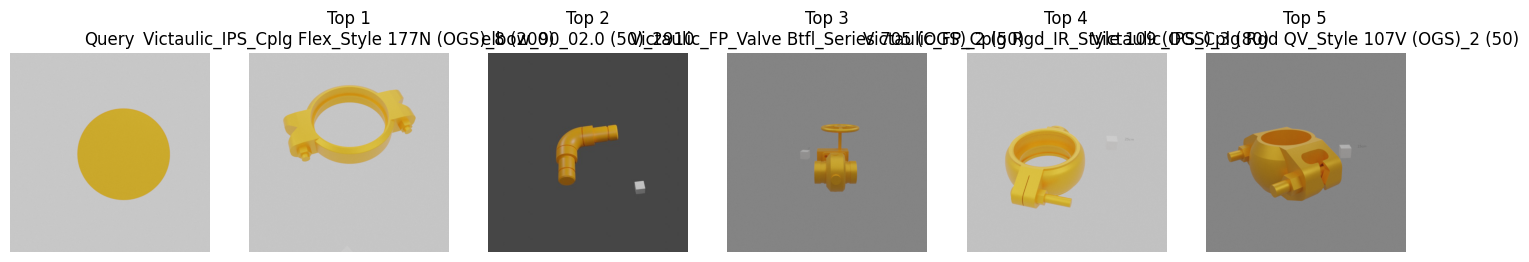

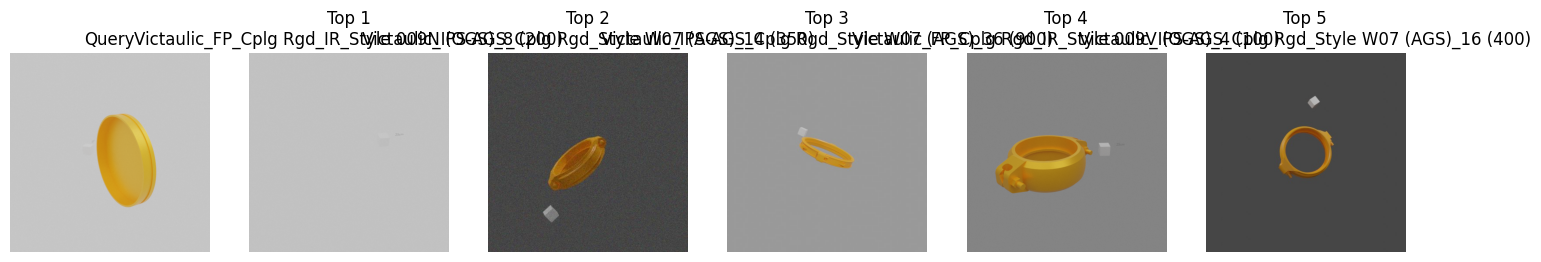

In [106]:
retrieve_similar(12, k=5)
retrieve_similar(44, k=5)
